In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


In [72]:
DATASET_PATH = "./Respiratory_Sound_Database"
AUDIO_PATH = os.path.join(DATASET_PATH, "audio_and_txt_files").replace("\\", "/")
LABELS_FILE = os.path.join(DATASET_PATH, "patient_diagnosis.csv")

labels_df = pd.read_csv(LABELS_FILE)
labels_df.columns = ['patient_id', 'disease']
labels_df['patient_id'] = labels_df['patient_id'].astype(str)
labels_df.head()


,patient_id,disease
0,102,Healthy
1,103,Asthma
2,104,COPD
3,105,URTI
4,106,COPD


In [74]:
print(labels_df)

    patient_id    disease
0          102    Healthy
1          103     Asthma
2          104       COPD
3          105       URTI
4          106       COPD
..         ...        ...
120        222       COPD
121        223       COPD
122        224    Healthy
123        225    Healthy
124        226  Pneumonia

[125 rows x 2 columns]


In [76]:
# 🎵 Feature extractor
def extract_features(file_path, max_pad_len=862):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [78]:
# 🔁 Augmentation

def augment_audio(file_path, num_augmented=3):
    augmented_samples = []
    try:
        y, sr = librosa.load(file_path, sr=None)
        for _ in range(num_augmented):
            choice = random.choice(['noise', 'stretch', 'pitch'])
            if choice == 'noise':
                noise = np.random.randn(len(y))
                y_aug = y + 0.005 * noise
            elif choice == 'stretch':
                rate = random.uniform(0.8, 1.2)
                y_aug = librosa.effects.time_stretch(y, rate=rate)
            elif choice == 'pitch':
                steps = random.randint(-2, 2)
                y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

            mfcc = librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=40)
            pad_width = 862 - mfcc.shape[1]
            if pad_width > 0:
                mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :862]

            augmented_samples.append(mfcc)
    except Exception as e:
        print(f"Error augmenting {file_path}: {e}")
    return augmented_samples

In [80]:
# 🧹 Load & augment dataset

data = []
labels = []

for filename in os.listdir(audio_path):
    if filename.endswith(".wav"):
        patient_id = filename.split('_')[0]
        match = labels_df[labels_df['patient_id'] == patient_id]
        if not match.empty:
            label = match['disease'].values[0]
            file_path = os.path.join(audio_path, filename)
            feature = extract_features(file_path)
            if feature is not None:
                data.append(feature)
                labels.append(label)
                if label in ['Bronchiectasis', 'Bronchiolitis', 'Pneumonia', 'URTI', 'LRTI']:
                    aug_feats = augment_audio(file_path, num_augmented=3)
                    for aug in aug_feats:
                        data.append(aug)
                        labels.append(label)


In [88]:
# 🧠 Final preprocessing
from collections import Counter

# Filter out classes with less than 2 samples for stratification
label_counts = Counter(labels)
filtered_data = []
filtered_labels = []

for feature, label in zip(data, labels):
    if label_counts[label] >= 2:
        filtered_data.append(feature)
        filtered_labels.append(label)

# Ensure proper shape for CNN input
data = np.array(filtered_data)
if data.ndim == 3:
    data = data[..., np.newaxis]  # Add channel dimension only if missing

le = LabelEncoder()
labels_encoded = le.fit_transform(filtered_labels)
num_classes = len(le.classes_)

X_train, X_test, y_train_labels, y_test_labels = train_test_split(
    data, labels_encoded, test_size=0.25, random_state=42, stratify=labels_encoded
)

y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes)

# 🏗️ CNN + GRU Model
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(40, 862, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Reshape((10, -1)),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 40, 862, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 431, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 431, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 20, 431, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 215, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10, 215, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 10, 13760)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │     5,309,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,337,095 (20.36 MB)

 Trainable params: 5,336,903 (20.36 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.8406 - loss: 0.7494 - val_accuracy: 0.6573 - val_loss: 1.2465
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - accuracy: 0.8313 - loss: 0.5023 - val_accuracy: 0.6742 - val_loss: 1.2174
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 466ms/step - accuracy: 0.7623 - loss: 0.5037 - val_accuracy: 0.6348 - val_loss: 1.1276
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 473ms/step - accuracy: 0.8154 - loss: 0.5062 - val_accuracy: 0.6461 - val_loss: 1.1964
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - accuracy: 0.8525 - loss: 0.3827 - val_accuracy: 0.6798 - val_loss: 1.1708
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 504ms/step - accuracy: 0.8718 - loss: 0.3313 - val_accuracy: 0.6742 - val_loss: 1.1444
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 463ms/step - accuracy: 0.8935 - loss: 0.2388 - val_accuracy: 0.6517 - val_loss: 1.1664
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 472ms/step - accuracy: 0.9022 - loss: 0.2427 - val_accu

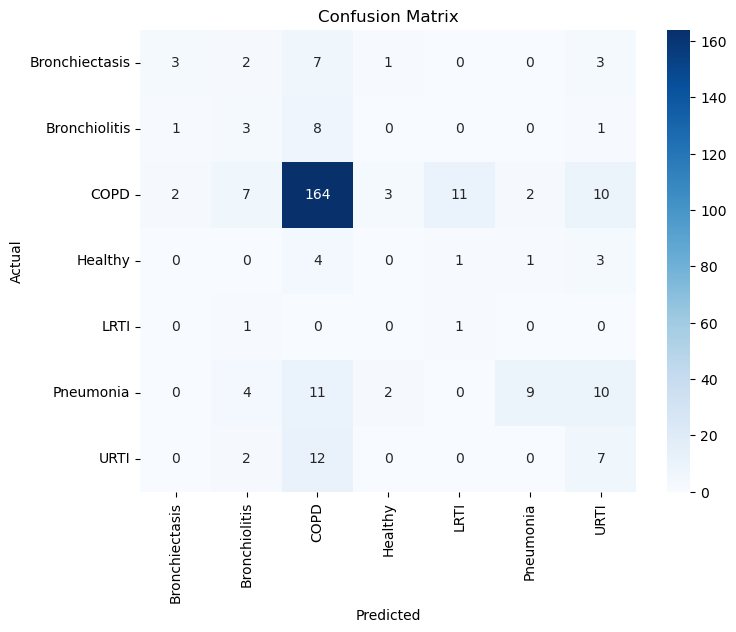

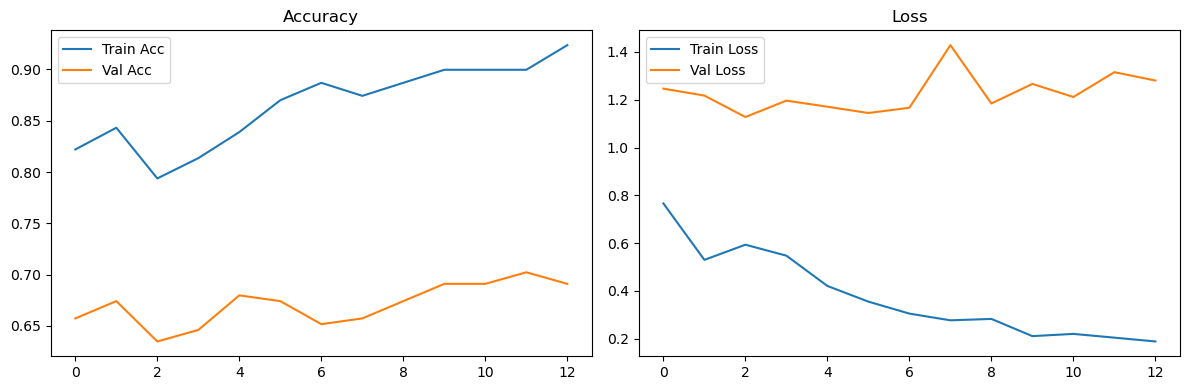

In [96]:
# 🚀 Train
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max'),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# 📊 Evaluation
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred_labels, target_names=le.classes_, zero_division=0))

# 🔍 Confusion Matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 📈 Training Curves
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()
